Aprendizaje Automático · Grado en Ingeniería Informática · Curso 2022/23
---
**Cuaderno 1** - Práctica 1: Predicción de la producción de energía solar
<br><br>
***Grupo Reducido 82 - Grupo de laboratorio 13***

# Requerimientos previos

## Imports

In [130]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Carga de datos

In [131]:
from google.colab import drive
data = pd.read_csv("stars_data.csv")

## Procesamiento de datos

Crearemos las diferentes pipelines con los datasets que utilizaremos más tarde para comparar los modelos.

Es decir, aplicaremos One-Hot Encoding y Ordinal Encoding, así como escalado y PCA.

### Encoding y Scaling

### One-Hot encoding

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


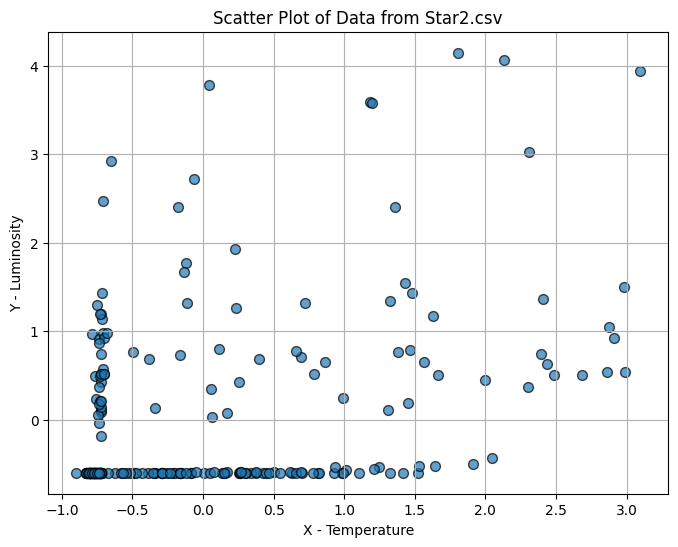

In [132]:
from sklearn.preprocessing import OneHotEncoder

# Separar las columnas numéricas
numeric_df = data.drop(columns=['Color', 'Spectral_Class'])

# Codificar la columna 'Color' con One-Hot-Encoding
encoder_color = OneHotEncoder(sparse=False)
categorical_np_color = encoder_color.fit_transform(data[['Color']])
encoded_df_color = pd.DataFrame(categorical_np_color, columns=encoder_color.get_feature_names_out(['Color']))

# Codificar la columna 'Spectral_Class' con One-Hot-Encoding
encoder_spectral_class = OneHotEncoder(sparse=False)
categorical_np_spectral_class = encoder_spectral_class.fit_transform(data[['Spectral_Class']])
encoded_df_spectral_class = pd.DataFrame(categorical_np_spectral_class, columns=encoder_spectral_class.get_feature_names_out(['Spectral_Class']))

# Concatenar los DataFrames codificados
encoded_data_ohe = pd.concat([numeric_df, encoded_df_color, encoded_df_spectral_class], axis=1)

# Escalado
columns_to_scale = encoded_data_ohe.columns
scaler = StandardScaler()
scaled_data_ohe = scaler.fit_transform(encoded_data_ohe)
scaled_df_ohe = pd.DataFrame(scaled_data_ohe, columns=columns_to_scale)

# Sacar x e y para el plot
x = scaled_df_ohe['Temperature']
y = scaled_df_ohe['L']


# Plot the data points
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=50, alpha=0.7, edgecolors='k')
plt.title('Scatter Plot of Data from Star2.csv')
plt.xlabel('X - Temperature')
plt.ylabel('Y - Luminosity')
plt.grid(True)
plt.show()


### Ordinal Encoder

In [133]:
from sklearn.preprocessing import OrdinalEncoder

# Preparar el mapping de los colores
mapping = {
    'Red': ['Red'],
    'Orange-Red': ['Orange-Red'],
    'Orange': ['Orange'],
    'Yellow-Orange': ['Pale yellow orange'],
    'Yellow': ['yellowish', 'Yellowish'],
    'White-Yellow': ['Yellowish White', 'yellow-white', 'White-Yellow'],
    'White': ['White', 'Whitish', 'white'],
    'Blue-White': ['Blue White', 'Blue white', 'Blue-white', 'Blue-White'],
    'Blue': ['Blue'],
}

# Formatear los nombres de los colores
for target_color, source_colors in mapping.items():
    data.loc[data.Color.isin(source_colors), 'Color'] = target_color

# Obtener una lista ordenada de los colores
ordered_colors = list(mapping.keys())

# Codificar la columna "Color" en el orden adecuado
encoder_color = OrdinalEncoder(categories=[ordered_colors])
encoded_color = encoder_color.fit_transform(data[['Color']])

# Codificar la columna "Spectral_Class" en el orden adecuado
ordered_spectral_class = ['O', 'B', 'A', 'F', 'G', 'K', 'M']
encoder_spectral_class = OrdinalEncoder(categories=[ordered_spectral_class])
encoded_spectral_class = encoder_spectral_class.fit_transform(data[['Spectral_Class']])

# Crear un DataFrame con las columnas codificadas
encoded_data_ord = pd.DataFrame({
    'Color': encoded_color.flatten(),
    'Spectral_Class': encoded_spectral_class.flatten()
})

# Concatenar los DataFrames codificados con las columnas numéricas originales
encoded_data_ord = pd.concat([numeric_df, encoded_data_ord], axis=1)

print(encoded_data_ord)

# Escalado
columns_to_scale = encoded_data_ord.columns
scaler = StandardScaler()
scaled_data_ord = scaler.fit_transform(encoded_data_ord)
scaled_df_ord = pd.DataFrame(scaled_data_ord, columns=columns_to_scale)



     Temperature              L          R    A_M  Color  Spectral_Class
0           3068       0.002400     0.1700  16.12    0.0             6.0
1           3042       0.000500     0.1542  16.60    0.0             6.0
2           2600       0.000300     0.1020  18.70    0.0             6.0
3           2800       0.000200     0.1600  16.65    0.0             6.0
4           1939       0.000138     0.1030  20.06    0.0             6.0
..           ...            ...        ...    ...    ...             ...
235        38940  374830.000000  1356.0000  -9.93    8.0             0.0
236        30839  834042.000000  1194.0000 -10.63    8.0             0.0
237         8829  537493.000000  1423.0000 -10.73    6.0             2.0
238         9235  404940.000000  1112.0000 -11.23    6.0             2.0
239        37882  294903.000000  1783.0000  -7.80    8.0             0.0

[240 rows x 6 columns]


# 1. Programación k-means

En esta primera parte implementaremos el algoritmo k-means y compararemos los resultados obtenidos con los de la aplicación de k-means a través de la biblioteca skctilearn. Para ello seguiremos las buenas prácticas de programación dividiendo el código en funciones, etc.

La implementación de k-means contará con los siguientes pasos:

En primer lugar, inicializar centroides.

Después, realizaremos los siguientes pasos:
1. Calculamos la distancia de cada punto al centroide.
2. Asignaremos cada punto al centroide mas cercano.
3. Cambiaremos los centroides al valor medio de todos los puntos asignados a este.

Repetiremos este proceso hasta que los centroides no cambien de lugar.


## Implementación K-means

Para el funcionamiento de k-means, para seguir las buenas prácticas de programación, hemos definido una función principal que llamará a una serie de funciones auxiliares que seguirán los pasos del algoritmo.

1. Inicializar centroides

In [134]:
def initialize_centroids(k, data):

    # obtenemos dimensiones de los datos
    n_dims = data.shape[1]

    # obtenemos minimo y máximo del conjunto
    centroid_min = data.min().min()
    centroid_max = data.max().max()

    # inicializamos los centroides
    centroids = []

    for centroid in range(k):
        # generación de centroide aleatorio
        centroid = np.random.uniform(centroid_min, centroid_max, n_dims)

        # se añade a la lista de centroides
        centroids.append(centroid)

    # Se transforma la lista en un dataframe
    centroids = pd.DataFrame(centroids, columns = data.columns)

    return centroids


2. Calcular el error

In [135]:
def calculate_error(a,b):

    # calculo del error cuadrático
    error = np.square(np.sum((a-b)**2))

    return error

3. Asignamos a los puntos al centroide más cercano.

In [136]:
def assign_centroid(data, centroids):

    # número de observaciones en el dataframe
    n_observations = data.shape[0]
    # asignación de centroides para cada observación
    centroid_assign = []
    # errores asociados a los centroides para cada observacón
    centroid_errors = []
    # número de centroides
    k = centroids.shape[0]

    for observation in range(n_observations):

        # cálculo del error
        errors = np.array([])
        for centroid in range(k):
            # cálculo del error entre la observación actual y cada centroide
            error = calculate_error(centroids.iloc[centroid, :2], data.iloc[observation,:2])
            errors = np.append(errors, error)

        # se calcula el centroide más cercano y su error
        closest_centroid =  np.where(errors == np.amin(errors))[0].tolist()[0]
        centroid_error = np.amin(errors)

        # asignamos los valores a las listas
        centroid_assign.append(closest_centroid)
        centroid_errors.append(centroid_error)

    return (centroid_assign,centroid_errors)

4. Función Kmeans.

Definiremos una función que aune el algoritmo k-means para poder aplicalo a nuetros datos.

In [137]:
def kmeans(data, k):

    # Inicializamos los centroides y su error
    centroids = initialize_centroids(k, data)
    error = []

    compr = True
    i = 0

    while(compr):
        # centroides y su error
        data['centroid'], iter_error = assign_centroid(data,centroids)
        error.append(sum(iter_error))

        # recalculamos los centroides
        centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

        # comprobamos que el error ha disminuido
        if(len(error)<2):
            compr = True
        else:
            if(round(error[i],3) !=  round(error[i-1],3)):
                compr = True
            else:
                compr = False
        i += 1

    # asignamos los centroides a cada observación y se recalculan los centroides finales
    data['centroid'], iter_error = assign_centroid(data,centroids)
    centroids = data.groupby('centroid').agg('mean').reset_index(drop = True)

    return (data['centroid'], iter_error, centroids)

In [138]:
def calculate_sse(data, centroids, labels):
    sse = 0
    for i, centroid in enumerate(centroids):
        sse += np.sum((data[labels == i] - centroid) ** 2)
    return sse

## Comparación k-means

Finalmente, aplicaremos el algoritmo a nuestros datos y visualizaremos el resultado.

Además, compararemos su rendimiento contra el de la funcion kmeans proporcionada por skcitlearn. Para ello, mediremos el tiempo de ejecución y la métrica silueta.

In [139]:
import time
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
colors = plt.cm.tab10.colors

Tiempo de ejecución: 3.507354974746704
Error:  2266.67705198244
Puntuación de silueta media: 0.577535421239845


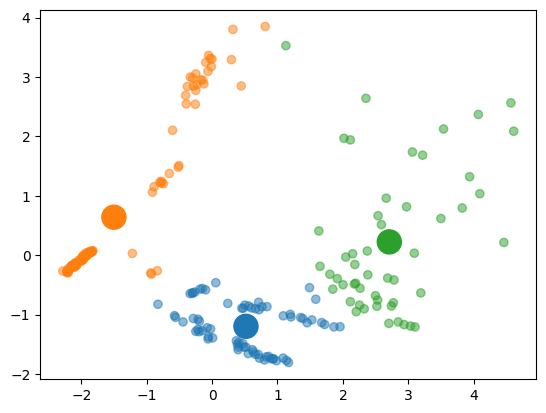

In [140]:
# Cogemos los datos codificados con Ordinal Encoding estandarizados y aplicamos PCA
pca = PCA(n_components=2)
or_st_pca_data = pca.fit_transform(scaled_data_ord)
or_st_pca = pd.DataFrame(or_st_pca_data)

start = time.time()
centroides, error, centroids =  kmeans(or_st_pca, 3) # Nuestro Kmeans con 3 centroides

end = time.time()
tiempo1 = end-start
error_total_1 = sum(error)
print("Tiempo de ejecución:", tiempo1)
print("Error: ", error_total_1)

plt.scatter(or_st_pca.iloc[:,0], or_st_pca.iloc[:,1],  marker = 'o', c = centroides.apply(lambda x: colors[x]), alpha = 0.5)
plt.scatter(centroids.iloc[:,0], centroids.iloc[:,1],  marker = 'o', s=300, c = centroids.index.map(lambda x: colors[x]))

# Métrica silueta
silhouette_avg1 = silhouette_score(or_st_pca, centroides)
print("Puntuación de silueta media:", silhouette_avg1)

En segundo lugar, compararemos los resultados obtenido entre nuetra implementación y kmeans a través de skcitlearn.

Para ello, aplicaremos kmeans con sckitlearn a los datos.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Tiempo de ejecución: 0.024587631225585938
Error:  414.8498719111859


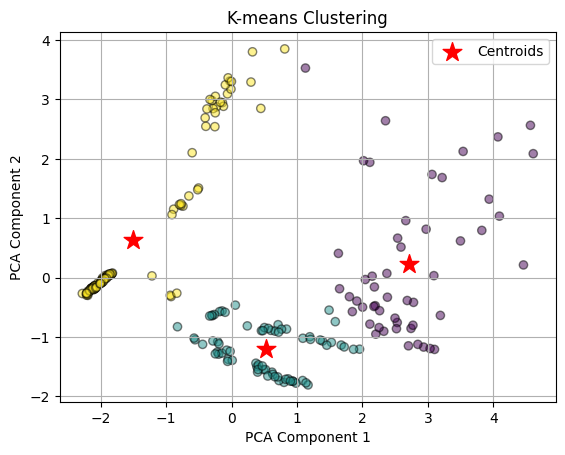

Puntuación de silueta media: 0.577535421239845


In [141]:
start = time.time()

kmeans2 = KMeans(n_clusters=3)
kmeans2.fit(or_st_pca.values)

end= time.time()
tiempo2 = end-start
print("Tiempo de ejecución:", tiempo2)
error_total_2 = kmeans2.inertia_
print("Error: ", error_total_2)

# Guardar centroides y etiquetas
centroids = kmeans2.cluster_centers_
labels = kmeans2.labels_

# Plotear datos
plt.scatter(or_st_pca.iloc[:,0], or_st_pca.iloc[:,1], c=labels, cmap='viridis', alpha=0.5, edgecolors='k')
# Plotear centroides
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=200, c='red', label='Centroids')


plt.legend()
plt.title('K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Métrica silueta
silhouette_avg2 = silhouette_score(or_st_pca, labels)
print("Puntuación de silueta media:", silhouette_avg2)

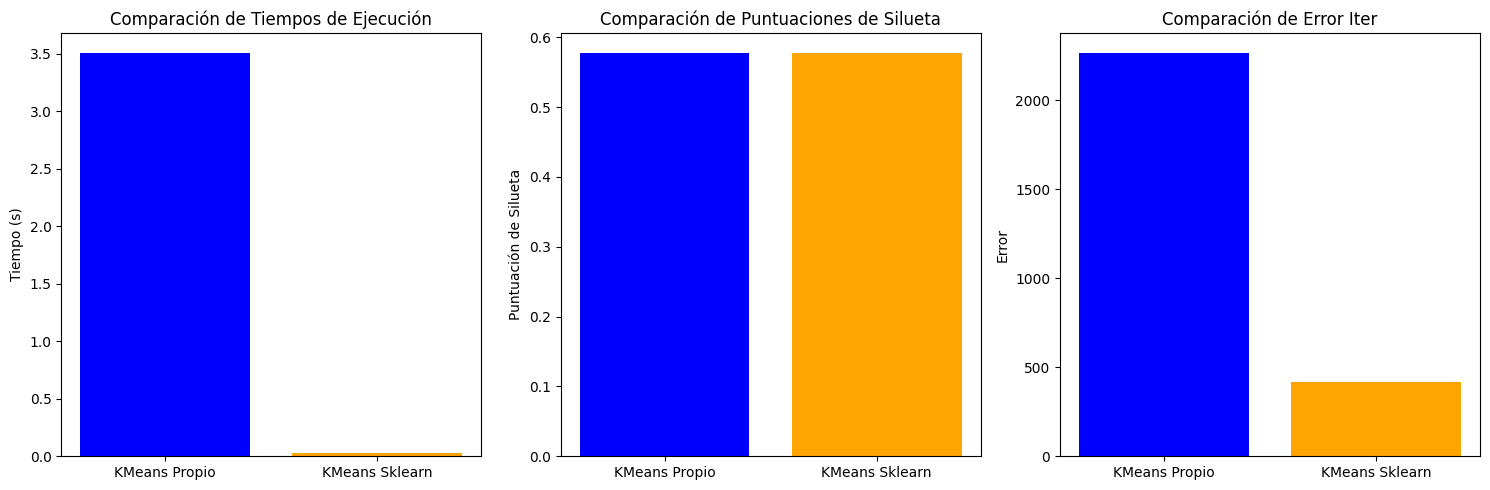

In [142]:
# Gráfico de barras para comparar tiempos de ejecución
plt.figure(figsize=(15, 5))  # Ajustar el tamaño de la figura
plt.subplot(1, 3, 1)  # Tres subplots en una fila
plt.bar(['KMeans Propio', 'KMeans Sklearn'], [tiempo1, tiempo2], color=['blue', 'orange'])
plt.title('Comparación de Tiempos de Ejecución')
plt.ylabel('Tiempo (s)')

# Gráfico de barras para comparar puntuaciones de silueta
plt.subplot(1, 3, 2)  # Tres subplots en una fila
plt.bar(['KMeans Propio', 'KMeans Sklearn'], [silhouette_avg1, silhouette_avg2], color=['blue', 'orange'])
plt.title('Comparación de Puntuaciones de Silueta')
plt.ylabel('Puntuación de Silueta')

# Gráfico de barras para comparar el error iter
plt.subplot(1, 3, 3)  # Tres subplots en una fila
plt.bar(['KMeans Propio', 'KMeans Sklearn'], [error_total_1, error_total_2], color=['blue', 'orange'])
plt.title('Comparación de Error Iter')
plt.ylabel('Error')

# Mostrar gráficos
plt.tight_layout()
plt.show()


Como podemos ver, el tiempo de ejecución de nuetsro kmeans es considerablemente mayor que el de la libreria skicitlearn, siendo la diferencia de entre 4 y 5 segundos. La métrica silueta es la misma, pero el error en nuestro kmeans es bastante mayor.

Además, kmeans mediante la biblioteca skicitlearn muestra reultados mucho más consistentes, devolviendo siempre tres centroides y ejecutandose en 0.14 segundos aproximadamente de manera continuada. Por otra parte, nuestra implementacion devuelve 2, 3 o 4 centroides, dependiendo de la iteración y hemos obtenido tiempos de ejecución de entre 4 y 5 segundos, lo cual es una diferencia considerable.

Por ello, considermos que es mucho mejor utilizar la biblioteca de skicit learn ya que aporta más consistencia, eficacia y facilidad a la hora de utilizarse; aunque la nuestra propia no sería una mala opción y podría servir para la tarea.

# 2. Comparación


Para la segunda parte de este ejercicio, compararemos el funcionamiento de varias pipelines en las que tendremos en cuenta los siguientes aspectos para los diferentes pasos:

1. Encoding.

  One-Hot encoding vs Ordinal encoding.
2. Escalado.

  Estandarización vs No estandarización.
3. Reducción de dimensiones.

  PCA vs No PCA.
4. Clustering.

  Kmeans vs DBSCAN.


En primer lugar, importaremos todas las librerias necesarias.

In [143]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import os
if not os.path.exists('plots'):
    os.makedirs('plots')
pipelines = ["oh_st_pca_kmeans", "oh_st_npc_kmeans", "oh_nst_npca_kmeans", "oh_st_pca_dbscan",
             "oh_st_npca_dbscan", "oh_nst_npca_dbscan", "or_st_pca_kmeans",
             "or_st_npca_kmeans", "or_nst_npca_kmeans", "or_st_pca_dbscan", "or_st_npca_dbscan",
             "or_st_npca_dbscan", "or_nst_npca_dbscan"]
metricas = {}

## One-Hot encoding, estandarización, PCA y Kmeans

### Elbow method

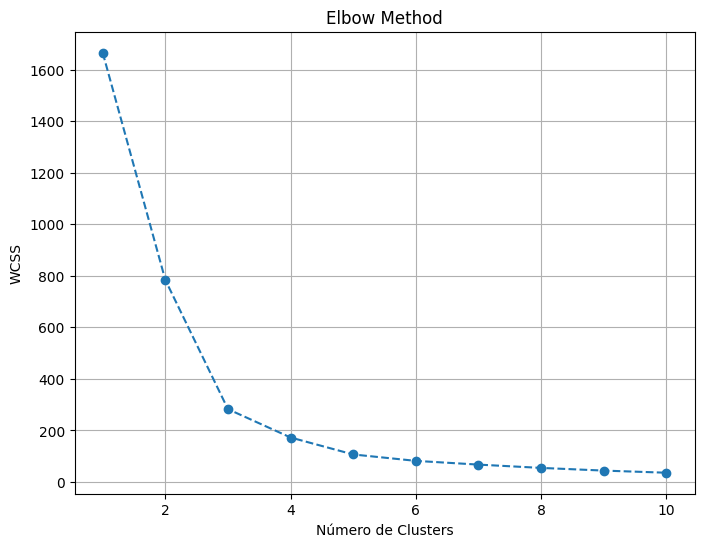

In [144]:
# Aplicar PCA a los datos

pca = PCA(n_components=2)
oh_st_pca_data = pca.fit_transform(scaled_data_ohe)
oh_st_pca = pd.DataFrame(oh_st_pca_data)

# Creamos una lista para almacenar los valores de WCSS (within-cluster sum of squares)
wcss = []

# Probamos diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
    kmeans.fit(oh_st_pca)
    wcss.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.title('Elbow Method')
plt.grid(True)
plt.show()

### Sihouette

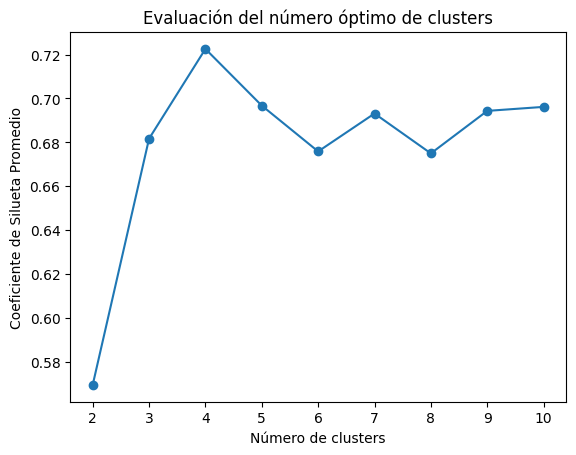

In [145]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Número máximo de clusters que deseas probar
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    # Aplicar el algoritmo de agrupamiento (en este caso, KMeans)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    labels = kmeans.fit_predict(oh_st_pca)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(oh_st_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes números de clusters
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del número óptimo de clusters')
plt.show()

### Kmeans

Silhouette Score: 0.7226027959839431


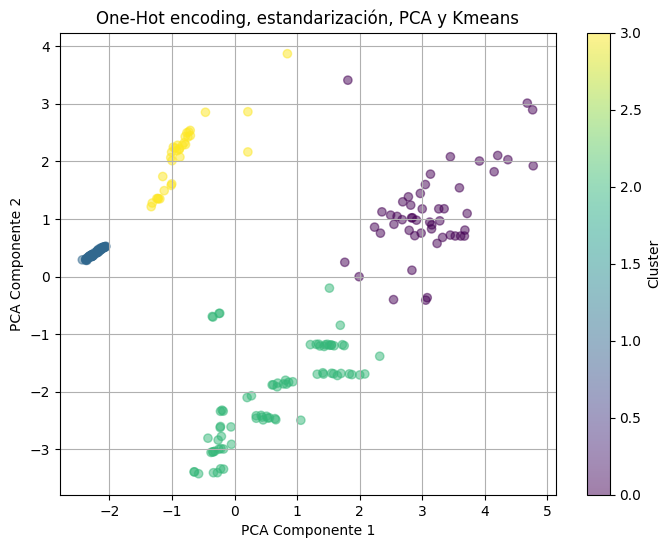

In [146]:
start = time.time()
# Clustering con KMeans en el espacio de las componentes principales
kmeans = KMeans(n_clusters=4, n_init=10)  # Número de clusters a utilizar
kmeans.fit(oh_st_pca)

end = time.time()
time1 = end-start

# Métrica silueta
labels = kmeans.labels_
silhouette_avg1 = silhouette_score(oh_st_pca, labels)
print("Silhouette Score:", silhouette_avg1)


metricas["oh_st_pca_kmeans"] = {'tiempo': time1, 'nota': silhouette_avg1}


# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(oh_st_pca.iloc[:, 0], oh_st_pca.iloc[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.title('One-Hot encoding, estandarización, PCA y Kmeans')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.savefig(os.path.join('plots', 'One-Hot_Estandarización_PCA_Kmeans.png'))
plt.show()


## One-Hot encoding, estandarización, no PCA y Kmeans

### Elbow method

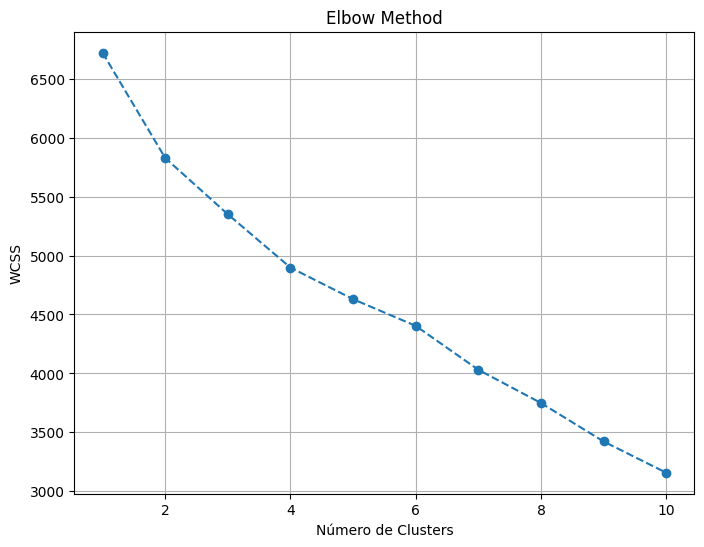

In [147]:
# Creamos una lista para almacenar los valores de WCSS (within-cluster sum of squares)

oh_st_npca = scaled_data_ohe
wcss = []

# Probamos diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(oh_st_npca)
    wcss.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.title('Elbow Method')
plt.grid(True)
plt.show()

### Silhouette

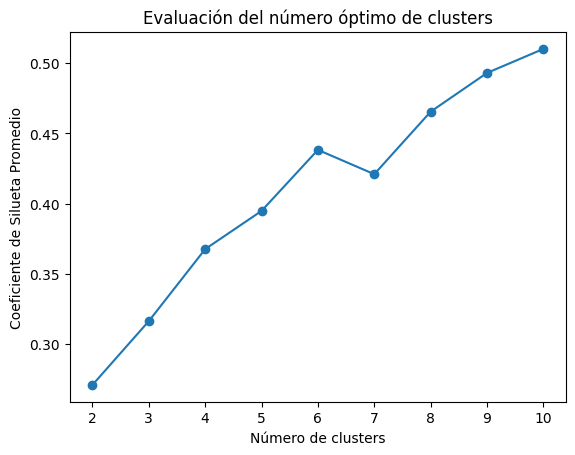

In [148]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Número máximo de clusters que deseas probar
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    # Aplicar el algoritmo de agrupamiento (en este caso, KMeans)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    labels = kmeans.fit_predict(oh_st_npca)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(oh_st_npca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes números de clusters
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del número óptimo de clusters')
plt.show()

Como vemos, al no usar PCA, los datos se cluterizan más fácilmente cuantos más clusters se usen, ya que hay demasiadas componentes (columnas) a tener en cuenta. De hecho, la máxima puntuación silueta que se puede obtener con 10 clusters es de poco más de 0.5, frente a más de 0.7 con 4 clusters si usamos PCA.

### Kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5133703659712937


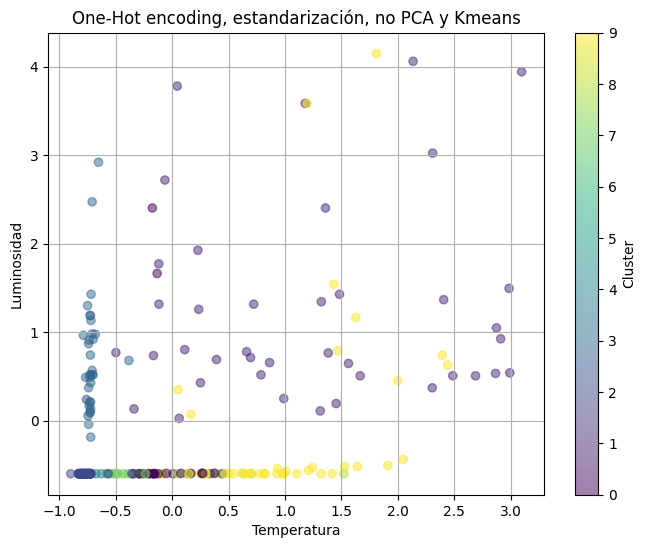

In [149]:
start = time.time()
# Clustering con KMeans en el espacio de las componentes principales
kmeans = KMeans(n_clusters=10)  # Número de clusters a utilizar
kmeans.fit(oh_st_npca)

end = time.time()
time2 = end - start

# Métrica silueta
labels = kmeans.labels_
silhouette_avg2 = silhouette_score(oh_st_npca, labels)
print("Silhouette Score:", silhouette_avg2)


metricas["oh_st_npc_kmeans"] = {'tiempo': time2, 'nota': silhouette_avg2}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(oh_st_npca[:, 0], oh_st_npca[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('One-Hot encoding, estandarización, no PCA y Kmeans')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


Como se puede obsevar, al no usar PCA, el resultado de la clusterización está horrible, muy poco claro y pobremente definido. Además, el KMeans se comporta de una manera muy extraña, ya que agrupa en el mismo cluster elementos que están muy lejos unos de otros, en ocasiones.

## One-Hot encoding, no estandarización, no PCA y Kmeans

### Elbow method

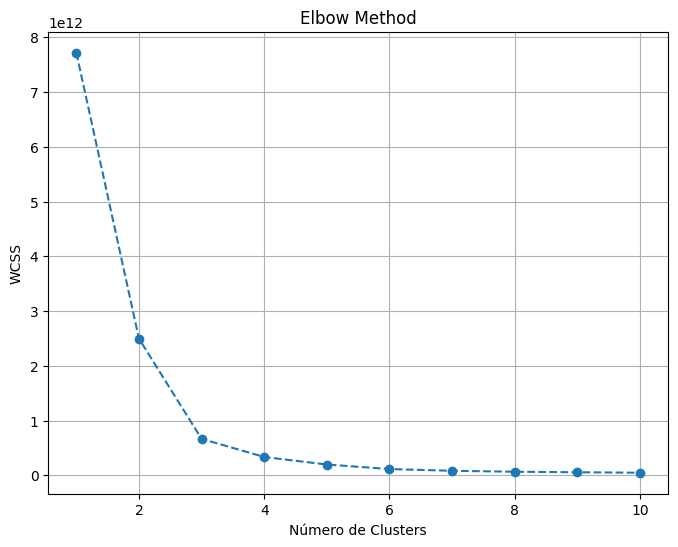

In [150]:
# Creamos una lista para almacenar los valores de WCSS (within-cluster sum of squares)
oh_nst_npca = encoded_data_ohe
wcss = []

# Probamos diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10)
    kmeans.fit(oh_nst_npca)
    wcss.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.title('Elbow Method')
plt.grid(True)
plt.show()


### Silhouette

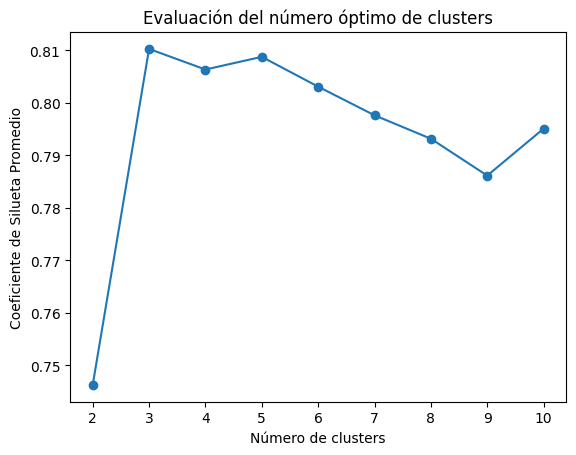

In [151]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Número máximo de clusters que deseas probar
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    # Aplicar el algoritmo de agrupamiento (en este caso, KMeans)
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10)
    labels = kmeans.fit_predict(oh_nst_npca)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(oh_nst_npca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes números de clusters
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del número óptimo de clusters')
plt.show()

### Kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.8102645810507881


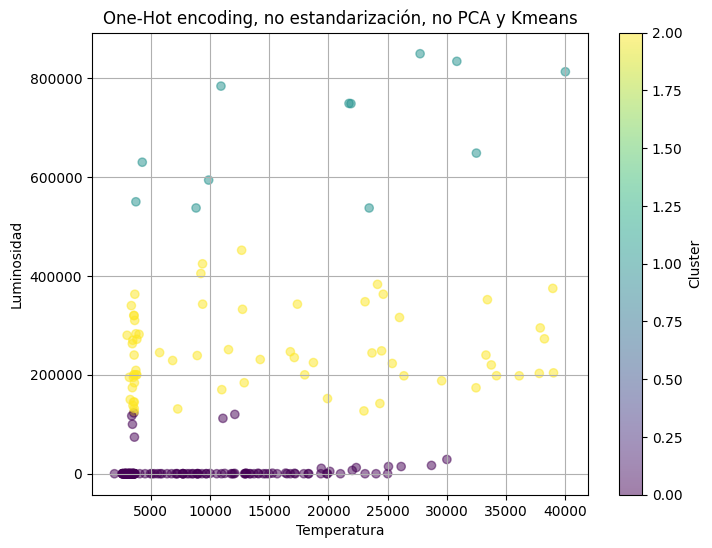

In [152]:
start = time.time()
# Clustering con KMeans en el espacio de las componentes principales
kmeans = KMeans(n_clusters=3)  # Número de clusters a utilizar
kmeans.fit(oh_nst_npca)

end = time.time()
time3 = end - start

# Métrica silueta
labels = kmeans.labels_
silhouette_avg3 = silhouette_score(oh_nst_npca, labels)
print("Silhouette Score:", silhouette_avg3)


metricas["oh_nst_npca_kmeans"] = {'tiempo': time3, 'nota': silhouette_avg3}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(oh_nst_npca['Temperature'], oh_nst_npca['L'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('One-Hot encoding, no estandarización, no PCA y Kmeans')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Al no hacer PCA ni estandardización, los métodos utilizados indican que lo más óptimo es utilizar 3 clusters, y así lo hacemos. En este caso, aunque no obtenemos resultados desconcertantes como en el apartado anterior, tampoco conseguimos unos clusters bien marcados ni que parezcan demasiado útiles para nuestro fin.

## One-Hot encoding, estandarización, PCA y DBSCAN

### Silhouette

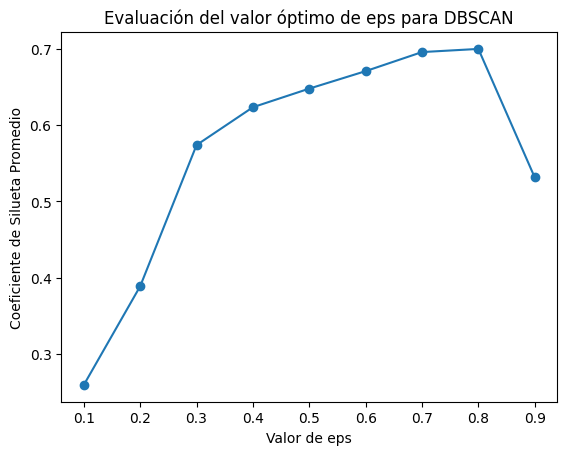

In [153]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Rango de valores para el parámetro eps (radio de la vecindad)
eps_values = np.arange(0.1, 1.0, 0.1)

for eps in eps_values:
    # Aplicar el algoritmo DBSCAN
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(oh_st_pca)

    silhouette_avg = silhouette_score(oh_st_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes valores de eps
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Valor de eps')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del valor óptimo de eps para DBSCAN')
plt.show()

### DBSCAN

Silhouette Score: 0.6997972885071687


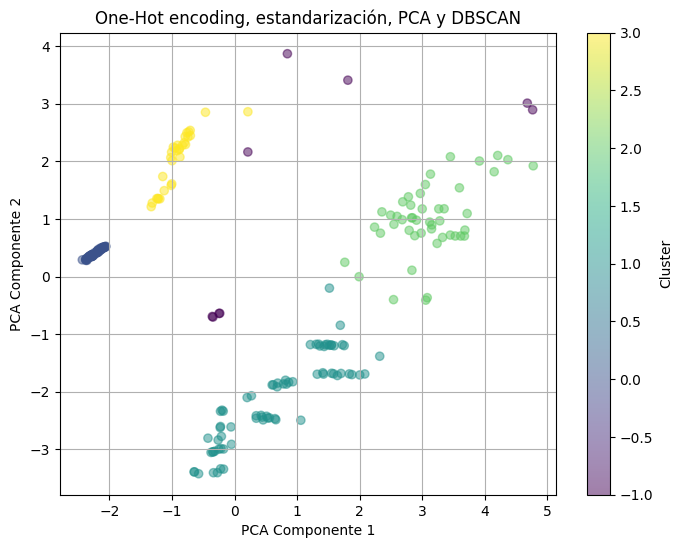

In [154]:
start = time.time()
# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan.fit(oh_st_pca)

end = time.time()
time4 = end - start

# Métrica silueta
labels = dbscan.labels_
silhouette_avg4 = silhouette_score(oh_st_pca, labels)
print("Silhouette Score:", silhouette_avg4)


metricas["oh_st_pca_dbscan"] = {'tiempo': time4, 'nota': silhouette_avg4}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(oh_st_pca.iloc[:, 0], oh_st_pca.iloc[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.title('One-Hot encoding, estandarización, PCA y DBSCAN')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.savefig(os.path.join('plots', 'One-Hot_Estandarización_PCA_dbscan.png'))
plt.show()

En este caso, obtenemos que el valor de eps para DBSCAN que maximiza la métrica silueta es 0.8, y así lo aplicamos en el DBSCAN, que genera 4 clusters que tienen buena pinta y podrían ser adecueados para clasificar nuestros datos.

## One-Hot encoding, estandarización, no PCA y DBSCAN

### Silhouette

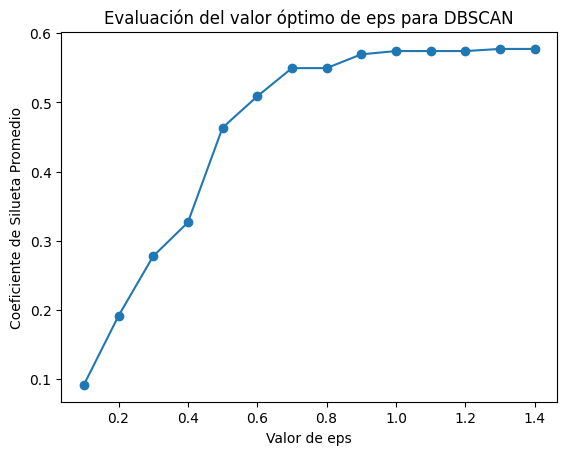

In [155]:
oh_st_npca = scaled_df_ohe

# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Rango de valores para el parámetro eps (radio de la vecindad)
eps_values = np.arange(0.1, 1.5, 0.1)

for eps in eps_values:
    # Aplicar el algoritmo DBSCAN
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(oh_st_npca)

    silhouette_avg = silhouette_score(oh_st_npca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes valores de eps
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Valor de eps')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del valor óptimo de eps para DBSCAN')
plt.show()

Como era de esperar al no usar PCA, obtenemos que cuanto mayor sea el valor de eps mayor será la puntuación silueta, sin alcanzar un tope óptimo en el rango de 0 a 1.5 para epsilon, ya que el valor de silueta se estanca por debajo de 0.6, que no es un valor muy prometedor. De todas formas, cogeremos el valor 0.9 para nuestros cálculos, ya que es el que alcanza el mayor valor de la puntuación silueta antes de su estancamiento.

### DBSCAN

Silhouette Score: 0.5694826106833695


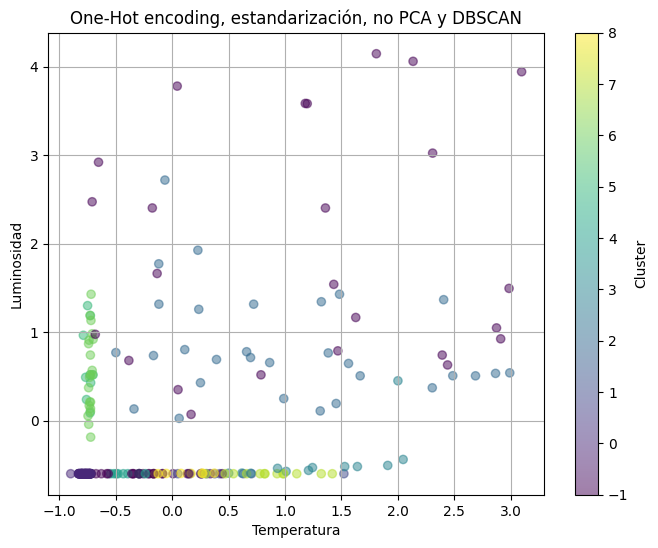

In [156]:
start = time.time()
# DBSCAN
dbscan = DBSCAN(eps=0.9, min_samples=5)  # Ajusta los parámetros según sea necesario
dbscan.fit(oh_st_npca)

end = time.time()
time5 = end - start

# Métrica silueta
labels = dbscan.labels_
silhouette_avg5 = silhouette_score(oh_st_npca, labels)
print("Silhouette Score:", silhouette_avg5)


metricas["oh_st_npca_dbscan"] = {'tiempo': time5, 'nota': silhouette_avg5}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(oh_st_npca['Temperature'], oh_st_npca['L'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('One-Hot encoding, estandarización, no PCA y DBSCAN')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Como vemos, el resultado de la clusterización no es convincente y el valor silueta está por debajo de 0.6.

## ERROR! - One-Hot encoding, no estandarización, no PCA y DBSCAN

### Silhouette

In [157]:
oh_nst_npca = encoded_data_ohe

# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Rango de valores para el parámetro eps (radio de la vecindad)
eps_values = np.arange(0.1, 1.5, 0.1)
i = 0
for eps in eps_values:

    print("i:", i)
    # Aplicar el algoritmo DBSCAN
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(oh_nst_npca)
    silhouette_avg = silhouette_score(oh_nst_npca, labels) # ERROR seguramente x no escalar los datos
    silhouette_scores.append(silhouette_avg)
    i += 1
    print("i:", i)

# Graficar el coeficiente de silueta para diferentes valores de eps
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Valor de eps')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del valor óptimo de eps para DBSCAN')
plt.show()

i: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Podemos ver como, al no escalar los datos ni redimensionarlos con PCA, obtenemos un error al aplicar el metodo slihouette

### DBSCAN

Silhouette Score: 0


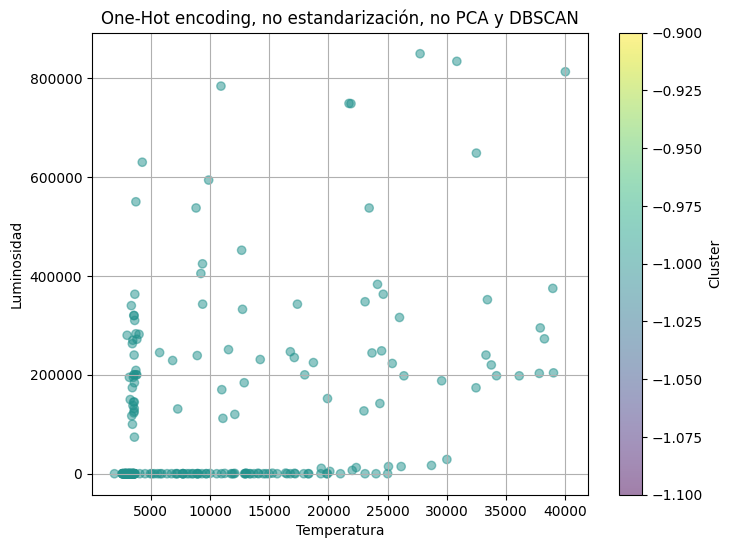

In [158]:
start = time.time()
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajusta los parámetros según sea necesario
dbscan.fit(oh_nst_npca)

end = time.time()
time6 = end - start

# Métrica silueta
labels = dbscan.labels_
silhouette_avg6 = 0
#silhouette_avg6 = silhouette_score(oh_nst_npca, labels) #ERROR??
print("Silhouette Score:", silhouette_avg6)



metricas["oh_nst_npca_dbscan"] = {'tiempo': time6, 'nota': silhouette_avg6}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(oh_nst_npca['Temperature'], oh_nst_npca['L'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('One-Hot encoding, no estandarización, no PCA y DBSCAN')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

## Ordinal encoding, estandarización, PCA y Kmeans

### Elbow method

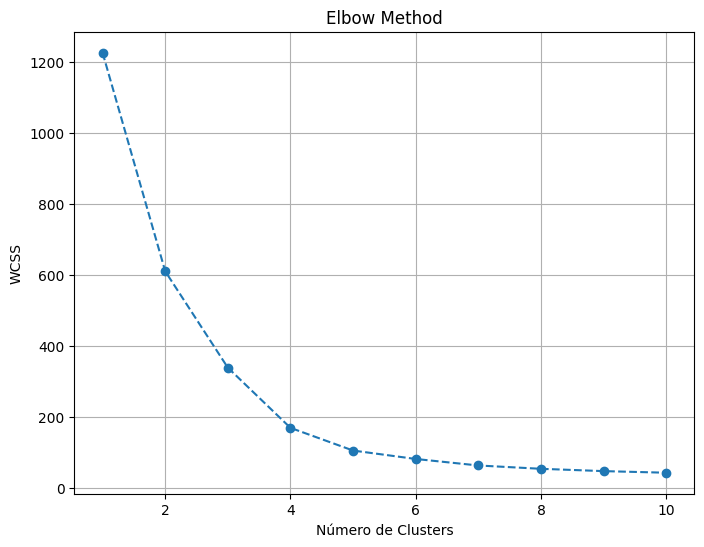

In [159]:
wcss = []
or_st_pca = or_st_pca.iloc[:, :2]

# Probamos diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10)
    kmeans.fit(or_st_pca)
    wcss.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.title('Elbow Method')
plt.grid(True)
plt.show()

### Silhouette

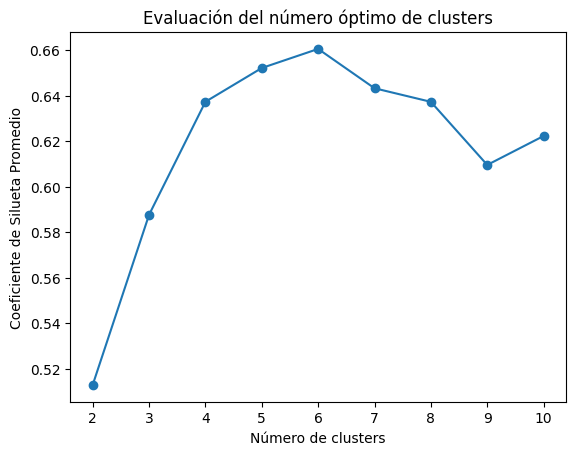

In [160]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Número máximo de clusters que deseas probar
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    # Aplicar el algoritmo de agrupamiento (en este caso, KMeans)
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10)
    labels = kmeans.fit_predict(or_st_pca)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(or_st_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes números de clusters
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del número óptimo de clusters')
plt.show()

### Kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.6222759609660464


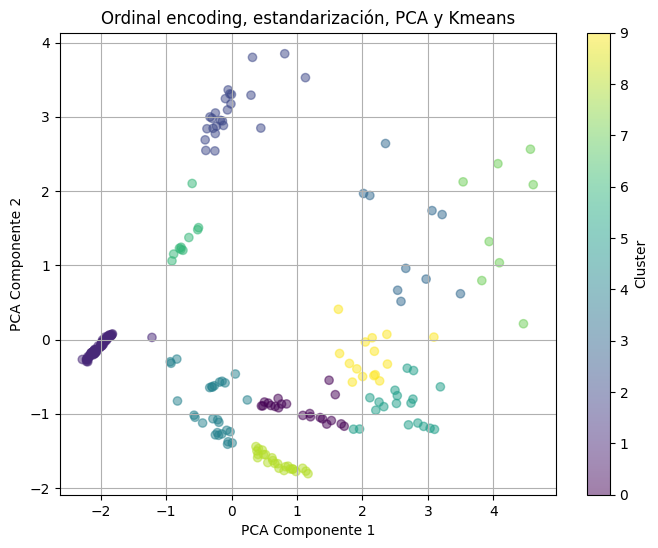

In [161]:
start = time.time()

# Clustering con KMeans en el espacio de las componentes principales
kmeans_definitivo = KMeans(n_clusters=5)  # Número de clusters a utilizar
kmeans_definitivo.fit(or_st_pca)

end = time.time()
time7 = end - start

# Métrica silueta
labels_definitivo = kmeans.labels_
silhouette_avg7 = silhouette_score(or_st_pca, labels_definitivo)
print("Silhouette Score:", silhouette_avg7)


metricas["or_st_pca_kmeans"] = {'tiempo': time7, 'nota': silhouette_avg7}


# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(or_st_pca.iloc[:, 0], or_st_pca.iloc[:, 1], c=labels_definitivo, cmap='viridis', alpha=0.5)
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.title('Ordinal encoding, estandarización, PCA y Kmeans')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Aunque en el silhouette obtengamos como valor máximo 6 clusters, el elbow method se aproxima más a 4 y, por lo que vemos, la mejora no es realmente significativa.

Siendo conservadores, hemos obtado por definir 5 clusters.

## Ordinal encoding, estandarización, no PCA y Kmeans

### Elbow method

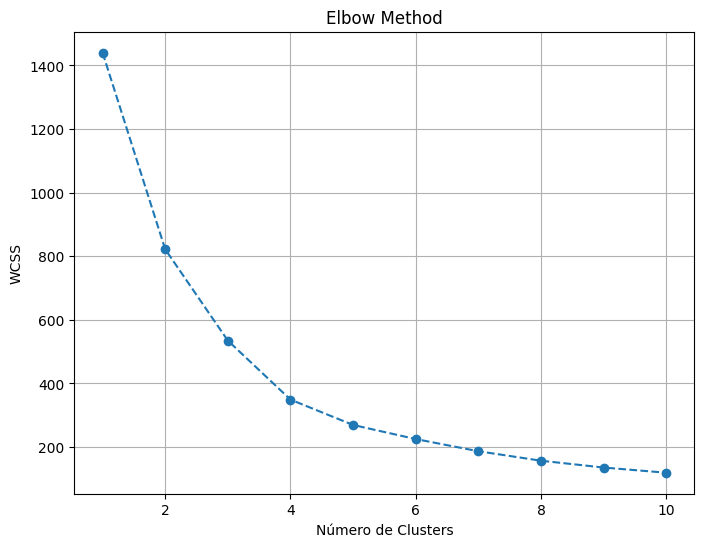

In [162]:
or_st_npca = scaled_df_ord
wcss = []

# Probamos diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10)
    kmeans.fit(or_st_npca)
    wcss.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.title('Elbow Method')
plt.grid(True)
plt.show()

### Silhouette

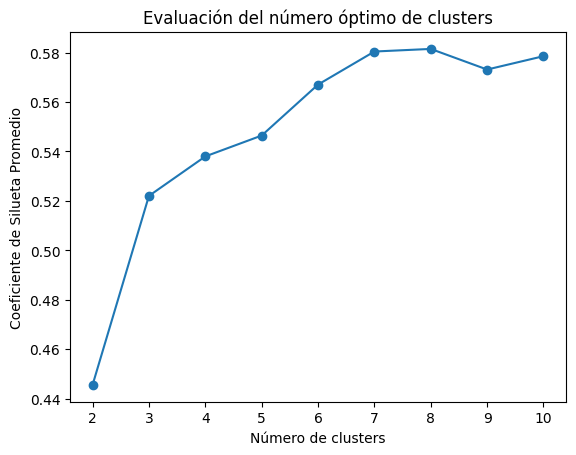

In [163]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Número máximo de clusters que deseas probar
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    # Aplicar el algoritmo de agrupamiento (en este caso, KMeans)
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10)
    labels = kmeans.fit_predict(or_st_npca)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(or_st_npca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes números de clusters
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del número óptimo de clusters')
plt.show()

### Kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.5380046725462295


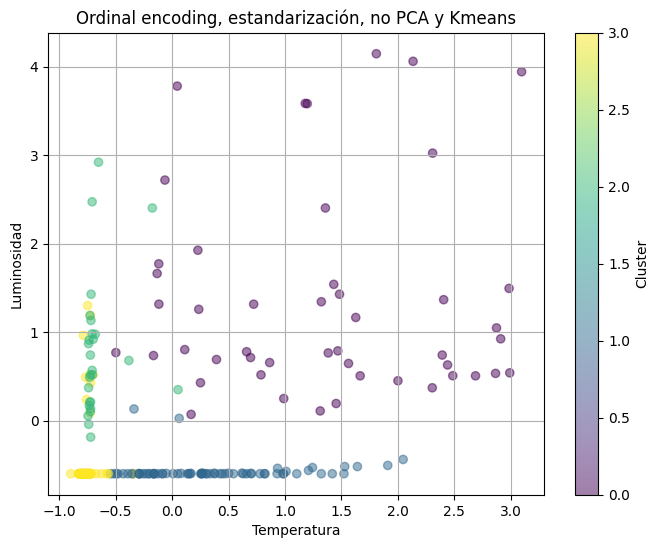

In [164]:
start = time.time()
# Clustering con KMeans en el espacio de las componentes principales
kmeans = KMeans(n_clusters=4)  # Número de clusters a utilizar
kmeans.fit(or_st_npca)

end = time.time()
time8 = end - start

# Métrica silueta
labels = kmeans.labels_
silhouette_avg8 = silhouette_score(or_st_npca, labels)
print("Silhouette Score:", silhouette_avg8)



metricas["or_st_npca_kmeans"] = {'tiempo': time8, 'nota': silhouette_avg8}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(or_st_npca['Temperature'], or_st_npca['L'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('Ordinal encoding, estandarización, no PCA y Kmeans')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Interpretando tanto el elbow method como el silhouette, definimos cuatro clusters. Aunqu el valor más alto en el segundo se obtenga con 8 clusters, vemos que la mejora más signicativa se realiza con 3 cluster y, junto con el elbow method, vemos que no merece la pena crear más, ya que, además, el resultado que se obtiene no es muy satisfactorio ni visualmente ni a nivel de Silhouette Score, probablemente por no usar PCA.

## Ordinal encoding, no estandarización, no PCA y Kmeans

### Elbow method

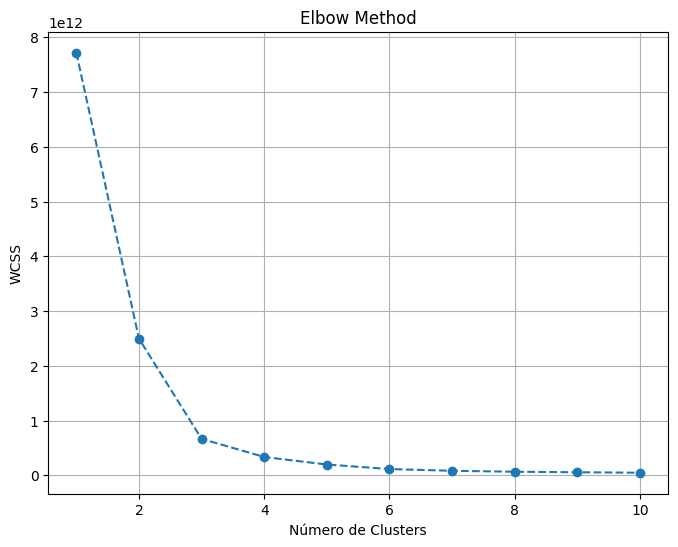

In [165]:
or_nst_npca = encoded_data_ord
wcss = []

# Probamos diferentes números de clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10)
    kmeans.fit(or_nst_npca)
    wcss.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.title('Elbow Method')
plt.grid(True)
plt.show()

### Silhouette

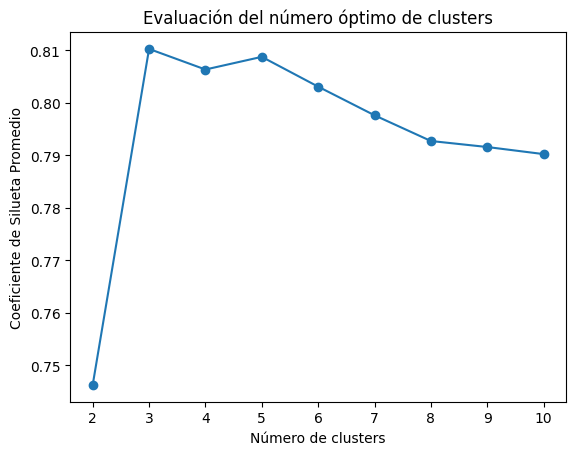

In [166]:
from sklearn.metrics import silhouette_score

# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Número máximo de clusters que deseas probar
max_clusters = 10

for n_clusters in range(2, max_clusters+1):
    # Aplicar el algoritmo de agrupamiento (en este caso, KMeans)
    kmeans = KMeans(n_clusters=n_clusters, n_init = 10)
    labels = kmeans.fit_predict(or_nst_npca)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(or_nst_npca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes números de clusters
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del número óptimo de clusters')
plt.show()

### Kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.8102645760867018


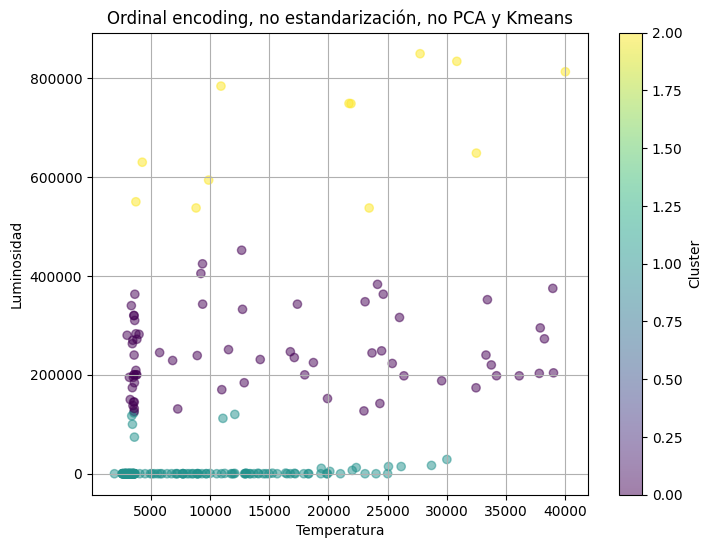

In [167]:
start = time.time()
# Clustering con KMeans
kmeans = KMeans(n_clusters=3)  # Número de clusters a utilizar
kmeans.fit(or_nst_npca)

end = time.time()
time9 = end - start

# Métrica silueta
labels = kmeans.labels_
silhouette_avg9 = silhouette_score(or_nst_npca, labels)
print("Silhouette Score:", silhouette_avg9)


metricas["or_nst_npca_kmeans"] = {'tiempo': time9, 'nota': silhouette_avg9}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(or_nst_npca['Temperature'], or_nst_npca['L'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('Ordinal encoding, no estandarización, no PCA y Kmeans')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Se obtiene un valor silueta muy alto, pero no unos clusters demasiado claros ni que se ajusten a la clasificación de nuestros datos, ya que al no usar PCA se tienen en cuenta solo las 2 primeras componentes, desestimando el resto de características a la hora de clasificar una estrella.

## Ordinal encoding, estandarización, PCA y DBSCAN

### Silhouette

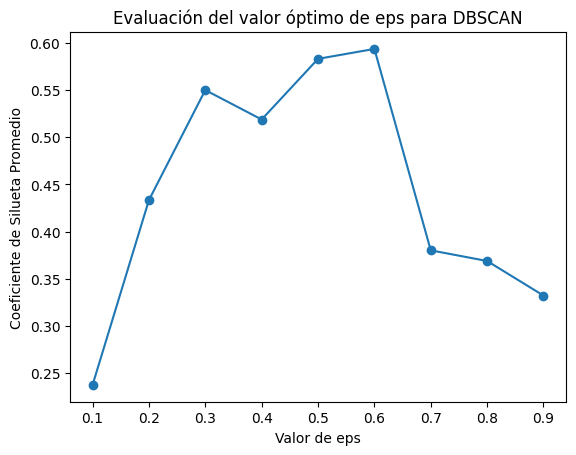

In [168]:

# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Rango de valores para el parámetro eps (radio de la vecindad)
eps_values = np.arange(0.1, 1.0, 0.1)

for eps in eps_values:
    # Aplicar el algoritmo DBSCAN
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(or_st_pca)

    silhouette_avg = silhouette_score(or_st_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes valores de eps
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Valor de eps')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del valor óptimo de eps para DBSCAN')
plt.show()

### DBSCAN

Silhouette Score: 0.5936205655191558


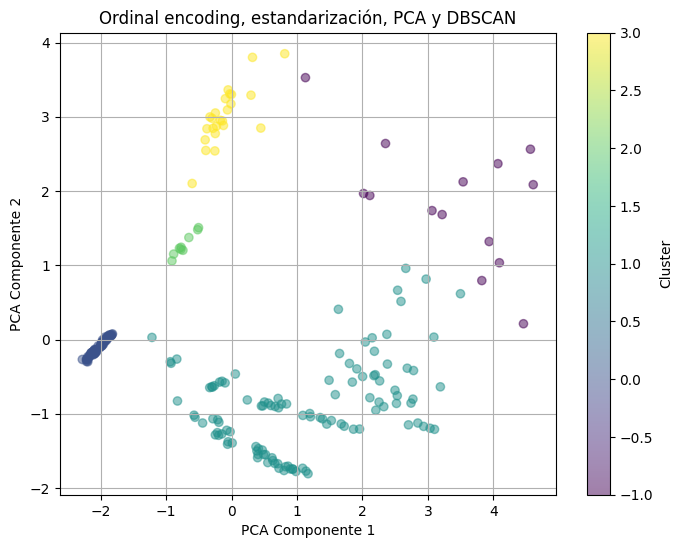

In [169]:
start = time.time()
# DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5)  # Ajusta los parámetros según sea necesario
dbscan.fit(or_st_pca)

end = time.time()
time10 = end - start

# Métrica silueta
labels = dbscan.labels_
silhouette_avg10 = silhouette_score(or_st_pca, labels)
print("Silhouette Score:", silhouette_avg10)


metricas["or_st_pca_dbscan"] = {'tiempo': time10, 'nota': silhouette_avg10}


# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(or_st_pca.iloc[:, 0], or_st_pca.iloc[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.title('Ordinal encoding, estandarización, PCA y DBSCAN')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()


Aunque la métrica silueta no es demasiado alta, obtenemos 5 clusters que podrían ser adecuados para la clasificación de nuestros datos.

## Ordinal encoding, estandarización, no PCA y DBSCAN

### Silhouette

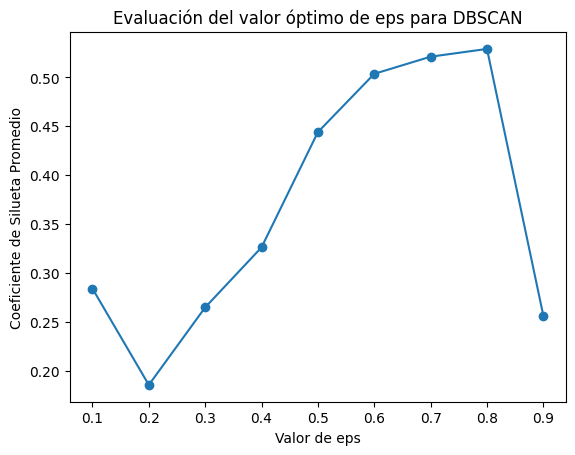

In [170]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Rango de valores para el parámetro eps (radio de la vecindad)
eps_values = np.arange(0.1, 1.0, 0.1)

for eps in eps_values:
    # Aplicar el algoritmo DBSCAN
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(or_st_npca)

    silhouette_avg = silhouette_score(or_st_npca, labels)
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes valores de eps
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Valor de eps')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del valor óptimo de eps para DBSCAN')
plt.show()

### DBSCAN

Silhouette Score: 0.3563728406884523


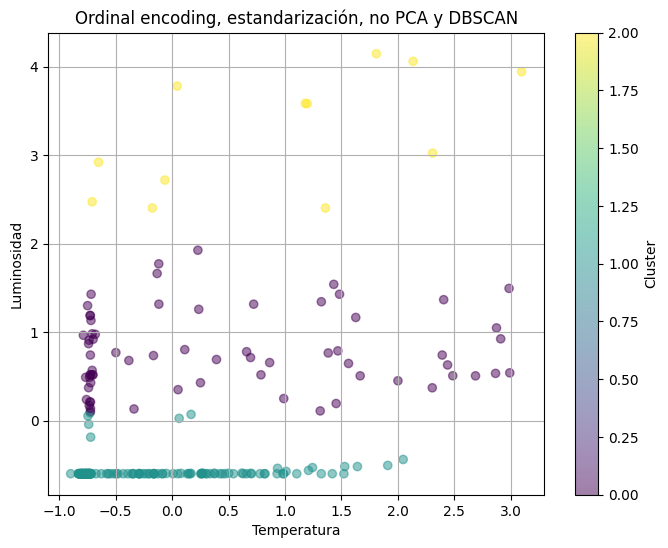

In [171]:
start = time.time()
# DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)  # Ajusta los parámetros según sea necesario
dbscan.fit(or_st_npca)

end = time.time()
time11 = end - start


# Métrica silueta
labels = kmeans.labels_
silhouette_avg11 = silhouette_score(or_st_npca, labels)
print("Silhouette Score:", silhouette_avg11)



metricas["or_st_npca_dbscan"] = {'tiempo': time11, 'nota': silhouette_avg11}

# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(or_st_npca.iloc[:, 0], scaled_df_ord.iloc[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('Ordinal encoding, estandarización, no PCA y DBSCAN')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.savefig(os.path.join('plots', 'Ordinal_Estandarización_NoPCA_dbscan.png'))
plt.show()

Se obtiene un valor de silueta muy bajo y 3 clusters no muy interesantes, al tener en cuenta solamente 2 de las componentes de nuestros datos.

## MISMO ERROR! - Ordinal encoding, no estandarización, no PCA y DBSCAN

### Silhouette

In [172]:
# Lista para almacenar los valores de coeficiente de silueta promedio
silhouette_scores = []

# Rango de valores para el parámetro eps (radio de la vecindad)
eps_values = np.arange(0.5, 0.6, 0.1)

for eps in eps_values:
    # Aplicar el algoritmo DBSCAN
    dbscan = DBSCAN(eps=eps)
    labels = dbscan.fit_predict(or_nst_npca)

    silhouette_avg = silhouette_score(or_nst_npca, labels) # ERROR
    silhouette_scores.append(silhouette_avg)

# Graficar el coeficiente de silueta para diferentes valores de eps
plt.plot(eps_values, silhouette_scores, marker='o')
plt.xlabel('Valor de eps')
plt.ylabel('Coeficiente de Silueta Promedio')
plt.title('Evaluación del valor óptimo de eps para DBSCAN')
plt.show()

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

### DBSCAN

Silhouette Score: 0.8102645760867018


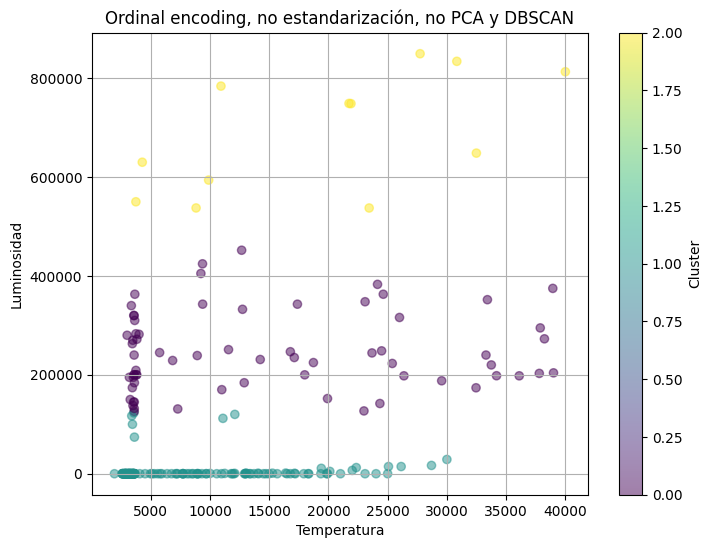

In [173]:
start = time.time()
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajusta los parámetros según sea necesario
dbscan.fit(or_nst_npca)

end = time.time()
time12 = end - start


# Métrica silueta
labels = kmeans.labels_
silhouette_avg12 = silhouette_score(or_nst_npca, labels)
print("Silhouette Score:", silhouette_avg12)


metricas["or_nst_npca_dbscan"] = {'tiempo': time11, 'nota': silhouette_avg12}


# Resultados
plt.figure(figsize=(8, 6))
plt.scatter(or_nst_npca['Temperature'], or_nst_npca['L'], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Luminosidad')
plt.title('Ordinal encoding, no estandarización, no PCA y DBSCAN')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Resultados

Tras utilizar las diferentes combinaciones de técnicas terminando con 12 algoritmos diferentes, hemos podido observar que el uso de One-Hot-Encoding o Ordinal Encoding no cambia mucho los clusters obtenidos en algunos casos, de hecho hay varios plots que tienen una forma muy parecida para ambas técnicas de codificación de variables categórica; aunque sí que es verdad que tan solo el Ordinal Encoder nos proporciona unos clusters que tienen una forma visual lineal, como si los grupos se formaran teniendo en cuenta principalmente el primer componente del pca o la temperatura en caso de no hacer pca.

Para comparar el rendimiento de las diferentes pipelines, mostraremos son tablas, una comparando su tiempo de ejecución y otra su silhouette score.

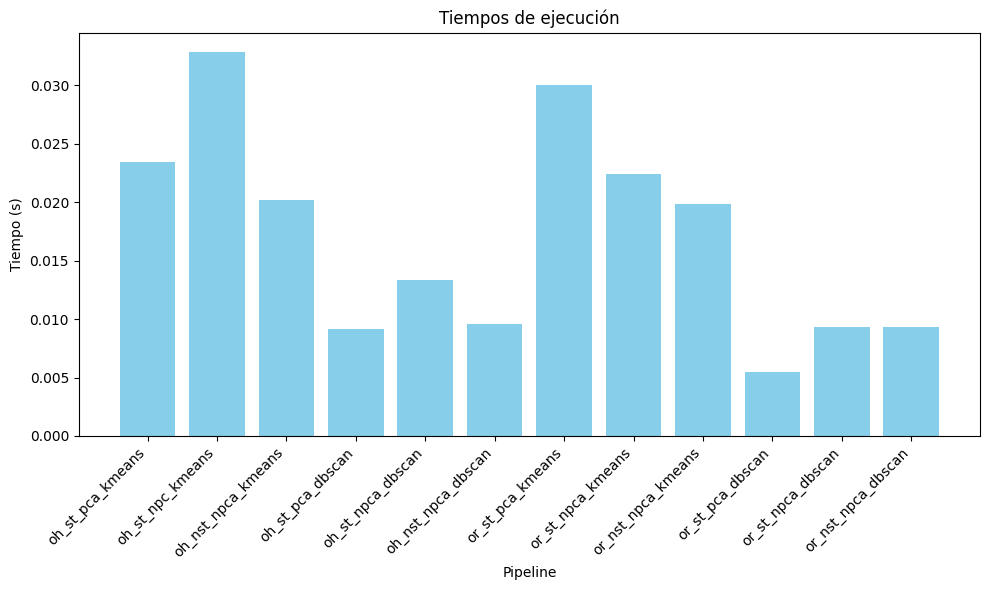

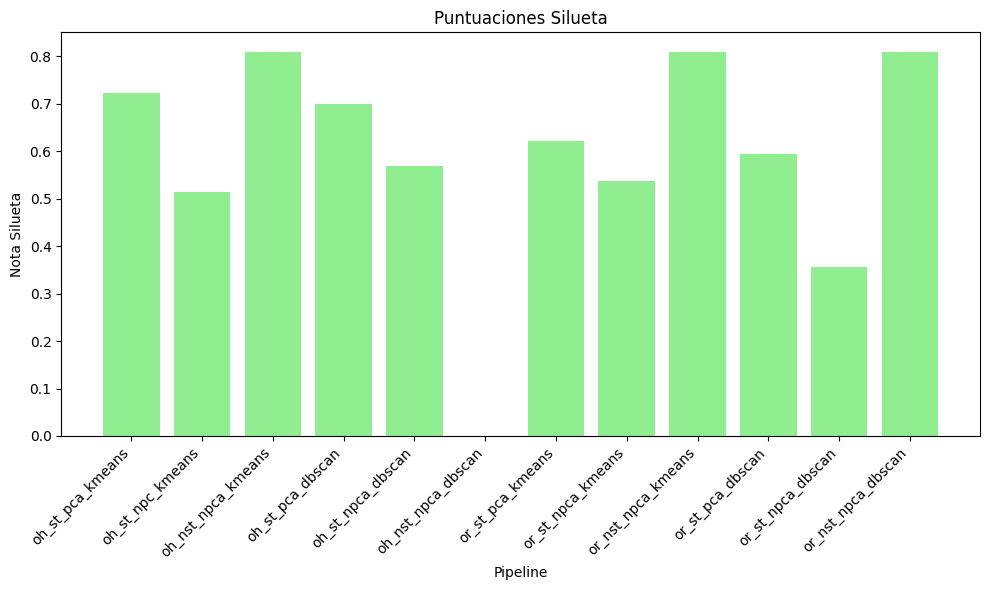

In [174]:
# Obtener los nombres de las pipelines, tiempos y notas
nombres_pipelines = list(metricas.keys())
tiempos = [value['tiempo'] for value in metricas.values()]
notas = [value['nota'] for value in metricas.values()]

# Crear el primer gráfico: nombre de la pipeline vs. tiempo
plt.figure(figsize=(10, 6))
plt.bar(nombres_pipelines, tiempos, color='skyblue')
plt.title('Tiempos de ejecución')
plt.xlabel('Pipeline')
plt.ylabel('Tiempo (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Crear el segundo gráfico: nombre de la pipeline vs. nota
plt.figure(figsize=(10, 6))
plt.bar(nombres_pipelines, notas, color='lightgreen')
plt.title('Puntuaciones Silueta')
plt.xlabel('Pipeline')
plt.ylabel('Nota Silueta')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Como podemos ver, las pipelines en las que no se aplica PCA, obtienen el silhouette más elevado de todos, con un tiempo de ejecución bastante bajo. Sin embargo, su visualización en una gráfica es bastante confusa, por lo que no estamos seguros de que sea el mejor método a la hora de formar clusters diferenciados, ya que la distancia entre puntos en este caso, dadas las múltiples variables que tenemos, se estaría haciendo en más de tres dimensiones.

Dentro de los metodos que sí utilizan PCA, obtenemos los mejores silhouette scores en OneHot encoding con estandarización y PCA tanto con kmeans como con DBSCAN, teniendo menor tiempo de ejecución el de DBSCAN pero siendo ligeramente más preciso el que utiliza Kmeans. Por otro lado, dentro de los métodos que utilizan ordinal encoding, el mejor sería aquel con los datos estandarizados y PCA con DBSCAN, teniendo en cuenta el tiempo de ejecución, ya que utilizando Kmeans el tiempo es considerablemente elevado.

Finalmente, nos hemos decantado por la siguiente opción: Ordinal Encoder, con Estandarización y con PCA y hecho con KMeans, priorizando la silhouette score, aunque en cuanto a la relación entre silhouette y tiempo, DBSCAN es ligeramente mejor ya que los clusters se ven menos diferenciados.

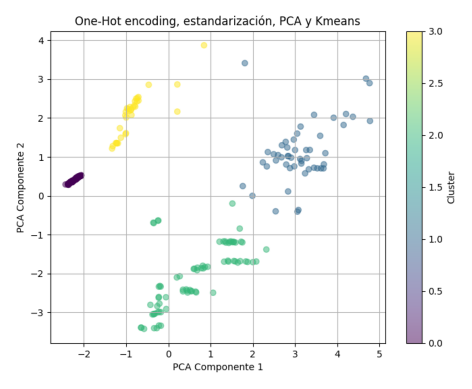

In [178]:
imagen = plt.imread(os.path.join("plots", "oh_st_pca_kmeans.png"))
plt.imshow(imagen)
plt.axis('off')
plt.show()

# Comparación con datos astronómicos

Finalmente, compararemos los datos del cluster elegido con los dados

In [182]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(or_st_pca)
or_st_pca = kmeans.labels_
Kmeans_df = data.copy()
Kmeans_df['cluster'] = or_st_pca
print("Datos con el cluster asignado por kmeans:")
display(Kmeans_df)

ValueError: Expected 2D array, got 1D array instead:
array=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 3. 3. 0. 0. 3. 3. 0. 0. 2. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0.
 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [180]:
for i in np.unique(or_st_pca):
  print(f"Cluster {i}")
  display(Kmeans_df[Kmeans_df['cluster']==i].head())
  describe=Kmeans_df[Kmeans_df['cluster']==i].describe()
  display(describe.loc["mean"])


Cluster 0


KeyError: 'cluster'

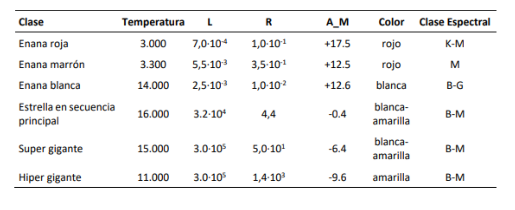

In [181]:
imagen = plt.imread(os.path.join("plots", "datos.png"))
plt.imshow(imagen)
plt.axis('off')
plt.show()

# Uso de fuentes y ChatGPT

Hemos utilizado ChatGPT a lo largo del proyecto para encontrar de manera rápida solución a problemas que nos han ido surgiendo como: aplicar DBSCAN o PCA, ya que es relativamente más rápido que buscarlo en internet o dentro del material de clase. También lo hemos utiliazdo para el desarrollo del algortimo Kmeans con promps como "cuáles son los pasos del algoritmo Kmeans" o "función en Python para inicializar los centroides".